In [1]:
dataset_base_path = r'/Users/piikn/ridho/dataset/processed'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
##from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
##from sklearn.naive_bayes import GaussianNB
##from sklearn.neighbors import KNeighborsClassifier
##from sklearn.tree import DecisionTreeClassifier
##from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import describe
from collections import Counter
from IPython.display import display
from time import time #time stamp for all processing time
from imblearn.over_sampling import SMOTENC


%matplotlib inline

In [3]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    if plot_pr:
        
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    print('\n')
    
def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

### 2. Prepocesing data

In [4]:
#join all csv
#split data jadi-2 X dan Y
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [10]:
#fitur yang nilainya 0 dicari 

stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

KeyError: MemoryError()

In [6]:
#fitur yang nilainya 0 dihapus
X = X.drop(columns=features_no_variance)

In [7]:
#fitur timestamp dan dst_port bertipe obyek, maka dihapus saja
X = X.drop(columns=['timestamp', 'dst_port'])

In [9]:
#Mencari fitur yang memiliki korelasi yang tinggi menggunakan Spearman rank-Order Corelation
import seaborn as sns
cluster_threshold = 1

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 40))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True), ax=ax1)

dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns, ax=ax2, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax2.plot([0, 1000], [cluster_threshold, cluster_threshold], ':r')
plt.show()

MemoryError: 

In [9]:
# The heatmap demonstrates that the dataset has a fair amount of features with high correlation amongst each other. 
#In order to remove redundant features the cluster distance threshold of 1 is used to pick features from their respective clusters
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0            Unnamed: 0
1              protocol
2         flow_duration
3          tot_fwd_pkts
4          tot_bwd_pkts
5       totlen_fwd_pkts
6       totlen_bwd_pkts
7      fwd_pkt_len_mean
8       fwd_pkt_len_std
9      bwd_pkt_len_mean
10          flow_byts_s
11          flow_pkts_s
12         flow_iat_std
13         flow_iat_min
14          fwd_iat_tot
15          fwd_iat_min
16          bwd_iat_tot
17          bwd_iat_min
18        fwd_psh_flags
19        fwd_urg_flags
20           bwd_pkts_s
21         fin_flag_cnt
22         rst_flag_cnt
23         psh_flag_cnt
24         ack_flag_cnt
25         urg_flag_cnt
26        down_up_ratio
27    init_fwd_win_byts
28    init_bwd_win_byts
29     fwd_seg_size_min
30          active_mean
31            idle_mean
dtype: object

In [10]:
#Fitur yang memiliki korelasi tinggi antar sesamanya dihapus

X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 32


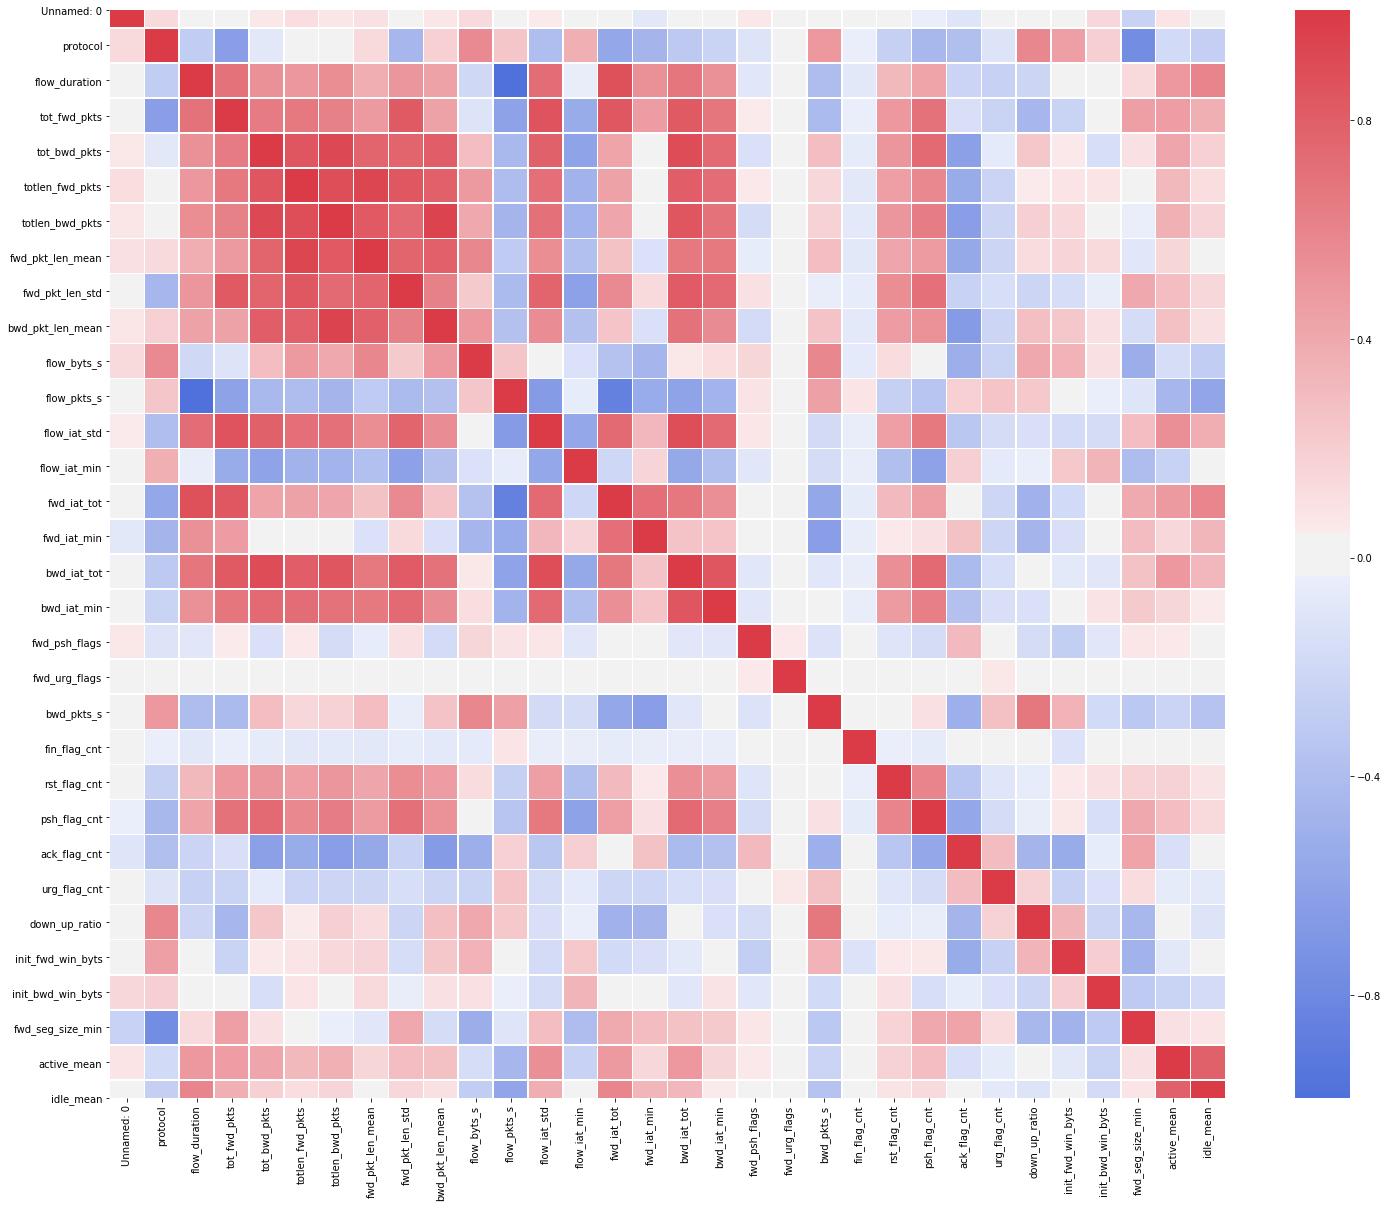

In [11]:

corr_updated = spearmanr(X).correlation
plt.figure(figsize=(25, 20))
sns.heatmap(corr_updated, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

In [21]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)
X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_cat)

##train_pool = Pool(X_train, y_train.label_is_attack, cat_features=['protocol'])
##eval_pool = Pool(X_eval, y_eval.label_is_attack, cat_features=['protocol'])
##test_pool = Pool(X_test, cat_features=['protocol'])

In [22]:
y_train.label_cat.value_counts()

0     10787766
4       548809
6       460953
8       369530
1       228953
11      154688
14      150071
12      129547
9       111912
7        33206
10        8792
5         1384
2          489
3          184
13          70
Name: label_cat, dtype: int64

In [23]:
percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    10787766
1     2198588
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.8307


In [24]:
## SMOTE

cnts = y_train.label_cat.value_counts()
sample_dict = {}

for i in np.unique(y_train.label_cat):
    sample_dict[i] = max(cnts[i], 100000)

In [28]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy=sample_dict, n_jobs=24, random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train.label_cat)

print('Class occurrences y_train:')
Counter(y_train_s)


C:\Users\piikn\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:324: UserWarning: After over-sampling, the number of samples (10787766) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1348471)
  n_samples_majority,


Class occurrences y_train:
Class occurrences y_eval:


Counter({0: 10787766,
         6: 460953,
         12: 129547,
         8: 369530,
         4: 548809,
         1: 228953,
         9: 111912,
         14: 150071,
         11: 154688,
         10: 100000,
         7: 100000,
         5: 100000,
         2: 100000,
         3: 100000,
         13: 100000})

In [41]:
y_train_s.()

TypeError: 'Series' object is not callable

In [35]:
##In this step we create the binary target variable by grouping all malicious network traffic into a single attack category represented by the positive class 1, whereas benign traffic is represented as the negative class 0.
y_train_is_attack = (y_train_s != 0).astype('int')

minority_class_weight = len(y_train_is_attack[y_train_is_attack == 0]) / len(y_train_is_attack[y_train_is_attack == 1])

class_weights = { 
    0: 1, 
    1: minority_class_weight
}

class_weights_catboost = [1, minority_class_weight]

## 4. Classifiers

In [45]:
## 1. baseline clasifier (dummy clasifier)

start_time = time()
cls_dummy = DummyClassifier('most_frequent')
cls_dummy.fit(X_train_s, y_train_is_attack)
end_time=time()
total=end_time-start_time
print_report('Train', cls_dummy, X_train_s, y_train_is_attack, cls_dummy.predict(X_train_s))
print_report('Eval', cls_dummy, X_eval, y_eval.label_is_attack, cls_dummy.predict(X_eval))
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.80      1.00      0.89  10787766
           1       0.00      0.00      0.00   2754463

    accuracy                           0.80  13542229
   macro avg       0.40      0.50      0.44  13542229
weighted avg       0.63      0.80      0.71  13542229

Avg Precision Score: 0.203398052122734


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91   1348471
           1       0.00      0.00      0.00    274823

    accuracy                           0.83   1623294
   macro avg       0.42      0.50      0.45   1623294
weighted avg       0.69      0.83      0.75   1623294

Avg Precision Score: 0.16929958467166145


Time to fit Data Train
0:00:00.60


In [46]:

##minority_class_weight = len(y_train[y_train.label_is_attack == 0]) / len(y_train[y_train.label_is_attack == 1])
    
clf_cb = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)

##cls_cb.fit(train_pool, eval_set=eval_pool)

clf_lr=LogisticRegression(solver='saga', n_jobs=-1, verbose=2)
##clf_lr=LogisticRegression()
clf_rf=RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
##clf_rf=RandomForestClassifier()


voting_clf= VotingClassifier(estimators=[('cb',clf_cb),('lr',clf_lr),('rf',clf_rf)],voting='hard')

##voting_clf.fit(X_train, y_train.label_is_attack)
for clf in (clf_cb,clf_lr, clf_rf, voting_clf):
 clf.fit(X_train_s, y_train_is_attack)
 y_pred = clf.predict(X_eval)
 print(clf.__class__.__name__, accuracy_score(y_eval.label_is_attack, y_pred))
print(classification_report(y_eval.label_is_attack, y_pred))

Learning rate set to 0.019977
0:	learn: 0.9569121	total: 319ms	remaining: 5m 18s
1:	learn: 0.9569121	total: 479ms	remaining: 3m 58s
2:	learn: 0.9569121	total: 642ms	remaining: 3m 33s
3:	learn: 0.9566246	total: 799ms	remaining: 3m 19s
4:	learn: 0.9569052	total: 960ms	remaining: 3m 11s
5:	learn: 0.9570708	total: 1.12s	remaining: 3m 5s
6:	learn: 0.9565621	total: 1.28s	remaining: 3m 1s
7:	learn: 0.9575050	total: 1.44s	remaining: 2m 57s
8:	learn: 0.9582267	total: 1.59s	remaining: 2m 54s
9:	learn: 0.9580499	total: 1.74s	remaining: 2m 52s
10:	learn: 0.9584471	total: 1.9s	remaining: 2m 50s
11:	learn: 0.9568065	total: 2.06s	remaining: 2m 49s
12:	learn: 0.9569368	total: 2.21s	remaining: 2m 48s
13:	learn: 0.9566656	total: 2.37s	remaining: 2m 46s
14:	learn: 0.9578027	total: 2.53s	remaining: 2m 46s
15:	learn: 0.9574893	total: 2.68s	remaining: 2m 45s
16:	learn: 0.9572192	total: 2.84s	remaining: 2m 44s
17:	learn: 0.9572359	total: 3s	remaining: 2m 43s
18:	learn: 0.9575227	total: 3.14s	remaining: 2m 42

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 1058 seconds


C:\Users\piikn\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 17.6min finished


LogisticRegression 0.8307004153283386


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.5s finished


RandomForestClassifier 0.9920975497968945
Learning rate set to 0.019977
0:	learn: 0.9569121	total: 166ms	remaining: 2m 46s
1:	learn: 0.9569121	total: 328ms	remaining: 2m 43s
2:	learn: 0.9569121	total: 490ms	remaining: 2m 42s
3:	learn: 0.9566246	total: 650ms	remaining: 2m 41s
4:	learn: 0.9569052	total: 808ms	remaining: 2m 40s
5:	learn: 0.9570708	total: 954ms	remaining: 2m 37s
6:	learn: 0.9565621	total: 1.11s	remaining: 2m 36s
7:	learn: 0.9575050	total: 1.25s	remaining: 2m 35s
8:	learn: 0.9582267	total: 1.4s	remaining: 2m 34s
9:	learn: 0.9580499	total: 1.56s	remaining: 2m 34s
10:	learn: 0.9584471	total: 1.73s	remaining: 2m 35s
11:	learn: 0.9568065	total: 1.89s	remaining: 2m 35s
12:	learn: 0.9569368	total: 2.05s	remaining: 2m 35s
13:	learn: 0.9566656	total: 2.21s	remaining: 2m 35s
14:	learn: 0.9578027	total: 2.35s	remaining: 2m 34s
15:	learn: 0.9574893	total: 2.5s	remaining: 2m 33s
16:	learn: 0.9572192	total: 2.65s	remaining: 2m 33s
17:	learn: 0.9572359	total: 2.8s	remaining: 2m 32s
18:	l

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 17.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.3s finished


VotingClassifier 0.9923778440627514


\### 4.5 Model selection

Comparing the models the following results are obtained:

|Model|Recall|Precision|F1|Avg PR|Recall Attack|Precision Attack|
|-----|---------|------|--|------|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.169|0.00|0.00|
|Logistic Regression|0.88|0.86|0.87|0.422|0.49|0.68|
|Random Forest|**0.99**|0.99|0.99|0.925|**0.95**|**0.96**|
|Gradient Boost|**0.99**|0.99|0.99|0.933|**0.96**|**0.97**|
|ensemble|0.893|0.00|0.00|0|0|

Gradient Boost performed best of all models and will be used as the final estimator.

In [12]:
estimator = cls_cb